In [5]:
import os
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
import time
import sys
import numpy as np
import pandas as pd
import random
import http.client

# Intro should include your high level story
1. How big is your population?
2. How big is your sample?
3. What are the features you have available?
4. What are you predicting?

In [10]:
#read in raw data
bv_data = pd.read_csv('bv_property_features.csv')


In [12]:
# Sort by date data was generated then remove records with duplicate addresses
# Keep only the oldest record to give us a better chance at a relevant sale record
bv_data.sort_values('roof_data_date', ascending = True, inplace = True)
bv_data.drop_duplicates(subset = 'full_address', keep = 'first', inplace = True)
bv_data.drop_duplicates(subset = 'zip', keep = 'first', inplace = True)
bv_data.reset_index(inplace = True, drop = True)
bv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28655 entries, 0 to 28654
Data columns (total 10 columns):
property_id        28655 non-null int64
roof_data_date     28655 non-null object
street             28648 non-null object
city               28622 non-null object
state              28655 non-null object
zip                28654 non-null object
full_address       28655 non-null object
visual_score       28654 non-null float64
detection_types    28655 non-null object
detections         28655 non-null object
dtypes: float64(1), int64(1), object(8)
memory usage: 2.2+ MB


In [15]:
print('The Visual Score for these properties is distributed as follows:')
bv_data.visual_score.describe()

The Visual Score for these properties is distributed as follows:


count    28654.000000
mean        82.821557
std         19.632121
min          0.058200
25%         73.231950
50%         89.584066
75%         98.376623
max         99.715704
Name: visual_score, dtype: float64

Text(0.5,1,'Visual Score Histogram')

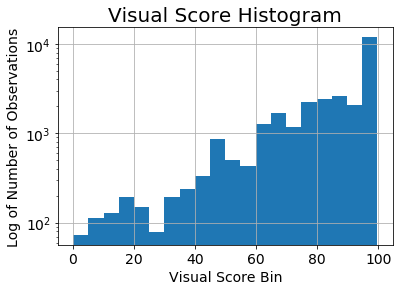

In [38]:
ax = bv_data.visual_score.hist(bins = 20, log = True, xlabelsize = 14, ylabelsize = 14)
ax.set_xlabel('Visual Score Bin', fontsize = 14)
ax.set_ylabel('Log of Number of Observations', fontsize = 14)
ax.set_title('Visual Score Histogram', fontsize = 20)


In [307]:
# Take a small sample for testing
bv_data_test = bv_data.iloc[:100, :]

In [311]:
bv_data.dropna(axis = 0, how = 'any', inplace = True)

In [326]:
row_counter = 600
total_rows = 76000
print('Completed {0:.2f}% of rows'.format(row_counter * 100 / total_rows))

Completed 0.79% of rows


## Scalable Scraping of Real Estate Page for Historical Estimate Data

First we must instantiate our web driver so that we can automate the navigation and data entry  for our scraping script.

In [22]:
chromedriver = "/Users/tylerpreston/bin/chromedriver"  # path to the chromedriver executable
chromedriver = os.path.expanduser(chromedriver)
sys.path.append(chromedriver)
driver = webdriver.Chrome(chromedriver)

In [23]:
url = 'https://realtor.com'
driver.get(url)

We start proving our concept by providing a short list of properties for our script to scrape:

In [83]:
addresses = first_30

In [25]:
element = driver.find_element_by_id('rdc-main-search-nav-hero-input')

In [26]:
search_string = address_list[0].lower()

In [27]:
for letter in search_string:
    element.send_keys(letter)
    time.sleep(np.random.exponential() * .2)
time.sleep(np.random.exponential() * .6)
element.send_keys(Keys.RETURN)

In [28]:
# pull page_source data with Beautiful Soup and save all scripts
soup = BeautifulSoup(driver.page_source, 'html.parser')
scripts = soup.find_all("script")

In [29]:
# Scripts are not organized/structured, so we are manually searching them for
# the desired data
estimate_dictionary = {}
for script in scripts:
    script = str(script)
    if 'avm_trend' in script:
        index = script.find('avm_trend')
        script = script[index: len(script)]
        start_index = script.find('{')
        stop_index = script.find('}') + 1
        estimate_dictionary[search_string] = json.loads(script[start_index:stop_index])['history']

In [30]:
driver.back()

In [31]:
element = driver.find_element_by_id('rdc-main-search-nav-hero-input')

In [32]:
search_string = address_list[1].lower()

for letter in search_string:
    element.send_keys(letter)
    time.sleep(np.random.exponential() * .2)
time.sleep(np.random.exponential() * .6)
element.send_keys(Keys.RETURN)

# Attom API for Easy Sales History

In [293]:
def get_property_detail(street, city, state, postal, key):
    address1 = ('%20').join(street.split())
    address2 = ('%20').join([city, state, postal])
    end_url = '/propertyapi/v1.0.0/property/detail?address1='\
        + address1 + "&address2=" + address2

    conn.request("GET", end_url, headers=headers)

    res = conn.getresponse()
    data = json.loads(res.read().decode('utf-8'))
    return data


def get_sales_history_by_address(street, city, state, postal, key):
    address1 = ('%20').join(street.split())
    address2 = ('%20').join((city + ' ' + state + ' ' + postal).split())
    end_url = '/propertyapi/v1.0.0/saleshistory/detail?address1='\
        + address1 + "&address2=" + address2

    conn.request("GET", end_url, headers=headers)

    res = conn.getresponse()
    sales_data = json.loads(res.read().decode('utf-8'))
    
    if sales_data['status']['code'] == 0:
        sales_data = sales_data['property'][0]['salehistory']
    else:
        sales_data = []
    return sales_data


def get_relevant_sale(sales_data, date):
    for sale in sales_data:
        try:
            sale_date = date_to_epoch(sale['amount']['salerecdate'])
        except:
            try:
                sale_date = date_to_epoch(sale['saleTransDate'])
            except:
                continue
        sale_amount = sale['amount']['saleamt']
        if sale_date > date and sale_amount > 0:
            return (sale_date, sale_amount)
    return ('null', 'null')

def date_to_epoch(date):
    if len(date) < 11:
        pattern = '%Y-%m-%d'
    else:
        date = date[0:10]
        pattern = '%Y-%m-%d'
    return int(time.mktime(time.strptime(date, pattern)))

def append_portfolio_sales_history(df):
    # Set up connection to the Attom API
    conn = http.client.HTTPSConnection("search.onboard-apis.com")

    headers = {
        'accept': "application/json",
        'apikey': key
    }
    
    # Iterate through rows of Betterview data to append relevant sales data
    relevant_sale_dates = []
    relevant_sale_amounts = []
    for label, row in df.iterrows():
        street, city, state, postal = row.street, row.city, row.state, row.zip
        date = date_to_epoch(row.roof_data_date)
        sales_data = get_sales_history_by_address(street, city, state, postal, key)
        relevant_sale = get_relevant_sale(sales_data, date)
        relevant_sale_dates.append(relevant_sale[0])
        relevant_sale_amounts.append(relevant_sale[1])
        time.sleep(.2)
   
    conn.close()    
        
    df['relevant_sale_date'] = pd.Series(relevant_sale_dates)
    df['relevant_sale_amount'] = pd.Series(relevant_sale_amounts)
    return df


In [174]:
# Obtain Attom API key from secure location
with open("/Users/tylerpreston/bin/config/attom_key.conf", 'r') as f:
    key = f.readline().strip()

In [246]:
# Execute everything above:
results = append_portfolio_sales_history(bv_data_test)
results.head()